In [6]:
from spiketimes.utils import p_adjust
from citalopram_project.load import get_data_dir, load_neurons, load_spikes
import pandas as pd
import seaborn as sns
from scipy.stats import mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest
sns.set_style("whitegrid")


sns.set()
sns.set_style("ticks")

neurons = (
    load_neurons()
    .loc[lambda x: x.group.isin(["sal", "continuation"])]
    [["session_name", "group"]]
    .drop_duplicates()
)
df_stats = (
    pd.read_parquet(get_data_dir() / "derived" / "spont_ensemble_stats.parquet.gzip")
    .assign(pval_sig=lambda x: p_adjust(x.score_pval) < 0.05)
)

df = (
    df_stats.merge(neurons, how="right")
    .assign(sig = lambda x: (x.pval_sig.fillna(False)) & (x["simmilarity"].fillna(False) > 0.1))
)

shock_sessions = load_spikes("base_shock").merge(load_neurons()[["neuron_id", "session_name"]])["session_name"].unique()
shock_sessions

array(['hamilton_01', 'hamilton_02', 'hamilton_13', 'hamilton_14',
       'hamilton_23', 'hamilton_07', 'hamilton_08', 'hamilton_19',
       'hamilton_20'], dtype=object)

In [7]:
# num mice, by group

df[["group", "session_name"]].groupby("group").size()

group
sal             12
continuation    19
dtype: int64

In [8]:
# num ensembles per group

df.loc[lambda x: x.sig][["group", "ensemble_id"]].groupby("group").size()

group
sal              7
continuation    11
dtype: int64

In [86]:
# num ensembles per mouse


props = df.groupby(["group", "session_name"]).apply(lambda x: x.sig.sum() >= 1).reset_index().groupby("group")[0].mean()

nobs = [12, 19]
count = [7, 11]
res = proportions_ztest(count, nobs)

print(props)
print(res)

group
sal             0.8
continuation    1.0
Name: 0, dtype: float64
(0.024104908912464623, 0.9807689277155198)


In [10]:
# prop neurons in ensembles

df_ensembles = pd.read_parquet(get_data_dir() / "derived" / "spont_ensembles.parquet.gzip")

all_neurons = (
    load_neurons()[["neuron_id", "session_name", "group"]]
    .loc[lambda x: x.session_name.isin(shock_sessions)]
    .merge(df_ensembles, how="left")
    .assign(in_ensemble=lambda x: ~x.ensemble_id.isnull())
)

props = all_neurons.groupby("group")["in_ensemble"].mean()

sal = all_neurons.loc[lambda x: x.group == "sal"]
cit = all_neurons.loc[lambda x: x.group == "continuation"]
n_obs = [len(sal), len(cit)]
counts = [sal["in_ensemble"].sum(), cit["in_ensemble"].sum()]
res = proportions_ztest(counts, n_obs)

print(props)
print(res)

group
sal             0.896552
continuation    0.490446
Name: in_ensemble, dtype: float64
(7.01723796064135, 2.262970210671453e-12)


In [88]:
# proportion in ensembles by group

by_mouse = (
    all_neurons
    .groupby(["session_name"], as_index=False)["in_ensemble"].mean()
    .merge(all_neurons[["session_name", "group"]].drop_duplicates())
)

props = all_neurons.groupby("group")["in_ensemble"].mean()

sal = all_neurons.loc[lambda x: x.group == "sal"]["in_ensemble"]
cit = all_neurons.loc[lambda x: x.group == "continuation"]["in_ensemble"]

res = mannwhitneyu(sal, cit)

print(props)
print(res)

group
sal             0.838710
continuation    0.480198
Name: in_ensemble, dtype: float64
MannwhitneyuResult(statistic=8034.0, pvalue=5.4998741291702556e-11)


In [89]:
# ensemble size by group

sizes = df.loc[lambda x: x.sig == True].groupby("group")["size"].mean()


sal = df.loc[lambda x: x.sig == True].loc[lambda x: x.group == "sal"]["size"]
cit = df.loc[lambda x: x.sig == True].loc[lambda x: x.group == "continuation"]["size"]

res = mannwhitneyu(sal, cit)

print(sizes)
print(res)

group
sal             17.0
continuation    11.0
Name: size, dtype: float64
MannwhitneyuResult(statistic=24.5, pvalue=0.10929391702718033)


In [90]:
# ensemble similarity

sizes = df.loc[lambda x: x.sig == True].groupby("group")["simmilarity"].mean()


sal = df.loc[lambda x: x.sig == True].loc[lambda x: x.group == "sal"]["simmilarity"]
cit = df.loc[lambda x: x.sig == True].loc[lambda x: x.group == "continuation"]["simmilarity"]

res = mannwhitneyu(sal, cit)

print(sizes)
print(res)

group
sal             0.176291
continuation    0.295806
Name: simmilarity, dtype: float64
MannwhitneyuResult(statistic=9.0, pvalue=0.004314238796423539)


In [91]:
# ensemble score

# ensemble similarity

sizes = df.loc[lambda x: x.sig == True].groupby("group")["score"].mean()


sal = df.loc[lambda x: x.sig == True].loc[lambda x: x.group == "sal"]["score"]
cit = df.loc[lambda x: x.sig == True].loc[lambda x: x.group == "continuation"]["score"]

res = mannwhitneyu(sal, cit)

print(sizes)
print(res)

group
sal             0.229194
continuation    0.304977
Name: score, dtype: float64
MannwhitneyuResult(statistic=20.0, pvalue=0.051529586727419786)


<AxesSubplot:xlabel='group', ylabel='in_ensemble'>

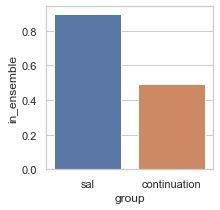

In [11]:
# figs: prop in ensemble
sns.set_style("whitegrid")
import matplotlib.pyplot as plt

all_neurons = (
    load_neurons()[["neuron_id", "session_name", "group"]]
    .loc[lambda x: x.session_name.isin(shock_sessions)]
    .merge(df_ensembles, how="left")
    .assign(in_ensemble=lambda x: ~x.ensemble_id.isnull())
)

plt.figure(figsize=(3, 3))

sns.barplot(data=all_neurons, x="group", y="in_ensemble", ci=None)
# plt.savefig("PROP NEURONS ENSEMBLE.svg")


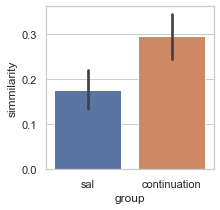

In [103]:
# figs: simmilarity

plt.figure(figsize=(3, 3))

df.loc[lambda x: x.sig].pipe((sns.barplot, "data"), x="group", y="simmilarity")
plt.savefig("ENSEMBLE SIMILARITY.svg")

In [23]:
# effect of cluster

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.discrete.discrete_model import DiscreteResults

all_neurons_clusters = all_neurons.merge(load_neurons()[["neuron_id", "cluster"]])
model = smf.glm("in_ensemble ~ group * cluster", family=sm.families.Binomial(), data=all_neurons_clusters).fit()
res = model.summary()
res

<class 'statsmodels.iolib.summary.Summary'>
"""
                              Generalized Linear Model Regression Results                              
=======================================================================================================
Dep. Variable:     ['in_ensemble[False]', 'in_ensemble[True]']   No. Observations:                  326
Model:                                                     GLM   Df Residuals:                      320
Model Family:                                         Binomial   Df Model:                            5
Link Function:                                           logit   Scale:                          1.0000
Method:                                                   IRLS   Log-Likelihood:                -190.67
Date:                                         Fri, 07 Jan 2022   Deviance:                       381.33
Time:                                                 07:31:37   Pearson chi2:                     326.
No. Iterations:                                              5                                         
Covariance Type:                                     nonrobust                                         
===================================================================================================================
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                          -0.5108      0.516     -0.989      0.323      -1.523       0.501
group[T.continuation]                               0.2877      0.701      0.410      0.682      -1.087       1.662
cluster[T.slow_irregular]                          -1.2599      0.643     -1.961      0.050      -2.519      -0.000
cluster[T.slow_regular]                            -1.5476      0.674     -2.295      0.022      -2.869      -0.226
group[T.continuation]:cluster[T.slow_irregular]     1.8084      0.826      2.190      0.029       0.190       3.427
group[T.continuation]:cluster[T.slow_regular]       1.6607      0.851      1.952      0.051      -0.007       3.328
===================================================================================================================
"""

In [37]:
# example ensemble

from citalopram_project.load import load_spikes
from citalopram_project.correlations import pairwise_correlation_spikes
import numpy as np 

def _reindex(df: pd.DataFrame, idx: np.ndarray) -> pd.DataFrame:
    idx = idx[np.isin(idx, df.columns)]
    df = df.reindex(idx)
    df = df[idx]
    return df

def get_index(df: pd.DataFrame, all_neurons: np.ndarray):
    ensemble_list = [
        df[df["ensemble_id"] == ensemble_name].neuron_id.unique()
        for ensemble_name in df.ensemble_id.unique().tolist()
    ]
    ensemble_neurons = np.concatenate(ensemble_list)
    non_ensemble_neurons = [n for n in all_neurons if n not in ensemble_neurons.tolist()]
    index = np.concatenate([ensemble_neurons, non_ensemble_neurons])
    return index

def plot_heatmap(session_name, df_spikes, df_ensembles, all_neurons, bin_width=1):
    df_corr = pairwise_correlation_spikes(df_spikes = df_spikes.loc[lambda x: x.session_name == session_name],
        bin_width = bin_width,
        rectify=True,
        fillna=True)
    idx = get_index(
        df_ensembles.loc[lambda x: x.session_name == session_name], 
        all_neurons.loc[lambda x: x.session_name == session_name]["neuron_id"].unique()
        )
    df_corr = _reindex(df_corr, idx)
    return sns.heatmap(df_corr, vmin=0, vmax=1, cmap="Greys")


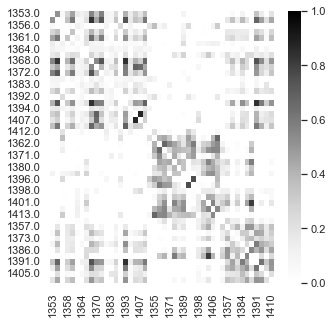

In [105]:
sal_sessions = load_neurons().loc[lambda x: x.group == "sal"]["session_name"].unique()
cit_sessions = load_neurons().loc[lambda x: x.group == "continuation"]["session_name"].unique()

df_spikes = (
    load_spikes("pre")
    .merge(load_neurons()[["neuron_id", "session_name"]])
)

session_name = sal_sessions[2]
plt.figure(figsize=(5, 5))
plot_heatmap(session_name, df_spikes, df_ensembles, all_neurons, bin_width=1)
plt.savefig("SAL CORR MAT 1.png")

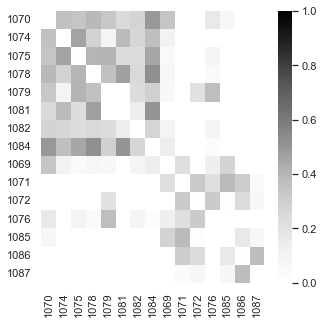

In [106]:
session_name = sal_sessions[0]
plt.figure(figsize=(5, 5))
plot_heatmap(session_name, df_spikes, df_ensembles, all_neurons, bin_width=1)
plt.savefig("SAL CORR MAT 2.png")

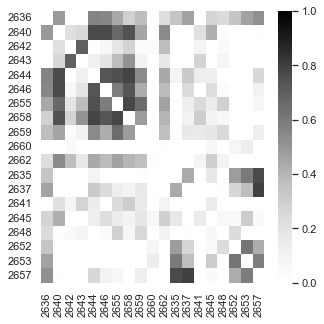

In [107]:
session_name = cit_sessions[6]
plt.figure(figsize=(5, 5))

plot_heatmap(session_name, df_spikes, df_ensembles, all_neurons, bin_width=1)
plt.savefig("CIT CORR MAT 1.png")

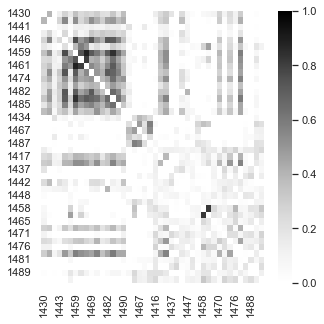

In [108]:
session_name = cit_sessions[3]
plt.figure(figsize=(5, 5))

plot_heatmap(session_name, df_spikes, df_ensembles, all_neurons, bin_width=1)
plt.savefig("CIT CORR MAT 2.png")

In [12]:
# overlap




In [80]:
df.loc[lambda x: x.session_name == sal_sessions[2]]

,ensemble_id,modularity,size,score,score_pval,simmilarity,session_name,ensemble_sig,pval_sig,group,sig
12,22.0,48.922865,25.0,0.158818,0.000333,0.113292,hamilton_07,True,True,sal,True
13,23.0,48.922865,15.0,0.345874,0.000000,0.234345,hamilton_07,True,True,sal,True
14,24.0,48.922865,15.0,0.170172,0.000333,0.168371,hamilton_07,True,True,sal,True


In [81]:
df.loc[lambda x: x.session_name == cit_sessions[6]]

,ensemble_id,modularity,size,score,score_pval,simmilarity,session_name,ensemble_sig,pval_sig,group,sig
27,50.0,25.800116,2.0,0.355674,0.00250,0.399118,chronic_01,False,True,continuation,True
28,51.0,25.800116,4.0,0.095061,0.11750,0.122210,chronic_01,False,False,continuation,False
29,52.0,25.800116,11.0,0.329014,0.00400,0.286132,chronic_01,True,True,continuation,True
30,53.0,25.800116,2.0,0.124340,0.07975,0.117687,chronic_01,False,False,continuation,False


In [82]:
df.loc[lambda x: x.session_name == cit_sessions[3]]

,ensemble_id,modularity,size,score,score_pval,simmilarity,session_name,ensemble_sig,pval_sig,group,sig
15,25.0,152.095105,30.0,0.080100,0.013,0.097973,hamilton_08,False,True,continuation,False
16,26.0,152.095105,23.0,0.301876,0.000,0.311876,hamilton_08,True,True,continuation,True
17,27.0,152.095105,2.0,0.429917,0.000,0.439040,hamilton_08,False,True,continuation,True
18,28.0,152.095105,5.0,0.313216,0.000,0.252352,hamilton_08,True,True,continuation,True
